In [1]:
import scanpy as sc
from anndata import read_h5ad
import pandas as pd
import numpy as np
import scipy as sp
from statsmodels.stats.multitest import multipletests
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import os
from os.path import join
import time
from gprofiler import GProfiler
import gseapy as gp

# scTRS tools
import scTRS.util as util
import scTRS.data_loader as dl
import scTRS.method as md

# autoreload
%load_ext autoreload
%autoreload 2

In [5]:
# Set file paths
DATA_PATH = '/n/holystore01/LABS/price_lab/Users/mjzhang/scTRS_data'
df_hom = pd.read_csv('/n/holystore01/LABS/price_lab/Users/mjzhang/scTRS_data/gene_annotation/'
                     'mouse_human_homologs.txt', sep='\t')
dic_map = {x:y for x,y in zip(df_hom['HUMAN_GENE_SYM'], df_hom['MOUSE_GENE_SYM'])}
dic_map_m2h = {y:x for x,y in zip(df_hom['HUMAN_GENE_SYM'], df_hom['MOUSE_GENE_SYM'])}
GS_FILE=DATA_PATH+'/gs_file/magma_10kb_1000.gs'
TRAIT_INFO_FILE=DATA_PATH+'/supp_table/trait_info.tsv'
FIG_PATH = '/n/holystore01/LABS/price_lab/Users/mjzhang/scTRS_data/results/fig_hep'

# Data set info
DS_LIST = ['facs', 'droplet', 'aizarani', 'halpern', 'richter', 'rao']
DIC_INFO = {}
DIC_INFO['facs'] = {'species': 'mmusculus', 'dname': 'TMS FACS'}
DIC_INFO['droplet'] = {'species': 'mmusculus', 'dname': 'TMS Droplet'}
DIC_INFO['aizarani'] = {'species': 'hsapiens', 'dname': 'Aizarani 2019'}
DIC_INFO['halpern'] = {'species': 'mmusculus', 'dname': 'Halpern Shenhav 2017'}
DIC_INFO['richter'] = {'species': 'mmusculus', 'dname': 'Richter Deligiannis 2020'}
DIC_INFO['rao'] = {'species': 'mmusculus', 'dname': 'Rao 2021'}

# Set score files
# Include n_genes as cov only for atlas. Include individual ID as covariates when available
DIC_SCORE_PATH = {'facs': DATA_PATH+'/score_file/score.tms_facs_with_cov.magma_10kb_1000',
                  'facs.hm': DATA_PATH+'/score_file/score.tms_facs_with_cov.hep_metabolic',
                  'droplet': DATA_PATH+'/score_file/score.tms_droplet_with_cov.magma_10kb_1000',
                  'droplet.hm': DATA_PATH+'/score_file/score.tms_droplet_with_cov.hep_metabolic',
                  'aizarani': DATA_PATH+'/score_file/score.liver_atlas.magma_10kb_1000',
                  'aizarani.hm': DATA_PATH+'/score_file/score.liver_atlas_with_cov.hep_metabolic', # n_genes
                  'halpern': DATA_PATH+'/score_file/score.mouse_liver_halpern.magma_10kb_1000', # no cov
                  'halpern.hm': DATA_PATH+'/score_file/score.mouse_liver_halpern.hep_metabolic',  
                  'richter': DATA_PATH+'/score_file/score.richter_with_cov.magma_10kb_1000', # ID.Individual
                  'richter.hm': DATA_PATH+'/score_file/score.richter_with_cov.hep_metabolic',  
                  'rao': DATA_PATH+'/score_file/score.rao_wang_with_cov.magma_10kb_1000', # sex
                  'rao.hm': DATA_PATH+'/score_file/score.rao_wang_with_cov.hep_metabolic',  
                 }

# Set trait list
DIC_TRAIT_LIST = {}
DIC_TRAIT_LIST['facs'] = ['UKB_460K.biochemistry_AlanineAminotransferase',
                          'UKB_460K.biochemistry_AlkalinePhosphatase',
                          'UKB_460K.biochemistry_Cholesterol',
                          'UKB_460K.biochemistry_HDLcholesterol',
                          'UKB_460K.biochemistry_LDLdirect',
                          'UKB_460K.biochemistry_SHBG',
                          'UKB_460K.biochemistry_Testosterone_Male',
                          'UKB_460K.biochemistry_TotalBilirubin',
                          'UKB_460K.biochemistry_Triglycerides', 
                          'UKB_460K.body_HEIGHTz', 'PASS_IBD_deLange2017']
DIC_TRAIT_LIST['facs.hm'] = ['CV', 'PN', 'hep4n_richter', 'hep2n_richter', 
                             'case_96hPH_vs_prePH', 'case_prePH_vs_96hPH', 
                             'case_vs_ctrl_96hPH', 'ctrl_vs_case_96hPH', 'large_vs_small',
                             'Glycolysis', 'Bile acid production', 'Lipogenesis', 'Xenobiotic metabolism',
                             'Beta-oxidation', 'Cholesterol biosynthesis', 'Protein secretion', 'Gluconeogenesis', 
                             ]
DIC_TRAIT_LIST['droplet'] = DIC_TRAIT_LIST['facs'].copy()
DIC_TRAIT_LIST['droplet.hm'] = DIC_TRAIT_LIST['facs.hm'].copy()
DIC_TRAIT_LIST['aizarani'] = DIC_TRAIT_LIST['facs'].copy()
DIC_TRAIT_LIST['aizarani.hm'] = DIC_TRAIT_LIST['facs.hm'].copy()
DIC_TRAIT_LIST['halpern'] = DIC_TRAIT_LIST['facs'].copy()
DIC_TRAIT_LIST['halpern.hm'] = DIC_TRAIT_LIST['facs.hm'].copy()
DIC_TRAIT_LIST['richter'] = DIC_TRAIT_LIST['facs'].copy()
DIC_TRAIT_LIST['richter.hm'] = DIC_TRAIT_LIST['facs.hm'].copy()
DIC_TRAIT_LIST['rao'] = DIC_TRAIT_LIST['facs'].copy()
DIC_TRAIT_LIST['rao.hm'] = DIC_TRAIT_LIST['facs.hm'].copy()

# Set trait info
DIC_HM_NAME = {'CV': 'pericentral',
               'PN': 'periportal',
               'hep4n_richter': '4n hep.',
               'hep2n_richter': '2n hep.',
               'case_96hPH_vs_prePH': 'polyploid (PH)',
               'case_prePH_vs_96hPH': 'diploid (PH)',
               'case_vs_ctrl_96hPH': 'polyploid (Cdk1 ko)',
               'ctrl_vs_case_96hPH': 'diploid (Cdk1 ko)',
               'large_vs_small': 'large hep.',
               'Beta-oxidation': 'beta-oxidation (PN)',
               'Cholesterol biosynthesis': 'cholesterol biosynthesis (PN)', 
               'Glycolysis': 'glycolysis (CV)', 
               'Protein secretion': 'protein secretion (PN)',
               'Bile acid production': 'bile acid production (CV)', 
               'Gluconeogenesis': 'gluconeogenesis (PN)', 
               'Lipogenesis': 'lipogenesis (CV)', 
               'Xenobiotic metabolism': 'xenobiotic metabolism (CV)'}

DF_TRAIT_INFO = pd.read_csv(TRAIT_INFO_FILE, sep='\t')
DF_TRAIT_INFO.index = DF_TRAIT_INFO['Trait_Identifier']
for trait in DF_TRAIT_INFO.index[DF_TRAIT_INFO['Code'].isna()]:
    trait_short = trait.replace('PASS_','').replace('UKB_460K.','')
    trait_short = trait_short.replace('blood_','').replace('disease_','')
    DF_TRAIT_INFO.loc[trait, 'Code'] = trait_short

for trait in DIC_HM_NAME:
    DF_TRAIT_INFO.loc[trait, 'Code'] = DIC_HM_NAME[trait]
    

### Load data 

In [6]:
# Load single-cell data 
dic_data_raw = {}
dic_data_raw['facs'] = dl.load_tms_ct(DATA_PATH, data_name='facs')
dic_data_raw['droplet'] = dl.load_tms_ct(DATA_PATH, data_name='droplet')
dic_data_raw['aizarani'] = dl.load_aizarani_raw_data(opt='raw')
dic_data_raw['halpern'] = dl.load_halpern_shenhav_raw_data(opt='raw')
dic_data_raw['richter'] = dl.load_richter_raw_data(opt='raw')
dic_data_raw['rao'] = dl.load_rao_raw_data(opt='raw')

dic_data_proc = {}
dic_data_proc['facs'] = read_h5ad('/n/holystore01/LABS/price_lab/Users/mjzhang/scTRS_data/single_cell_data/tms_proc/'
                                  'hep.facs_annot.h5ad')
dic_data_proc['droplet'] = read_h5ad('/n/holystore01/LABS/price_lab/Users/mjzhang/scTRS_data/single_cell_data/tms_proc/'
                                  'hep.droplet.h5ad')
dic_data_proc['aizarani'] = read_h5ad('/n/holystore01/LABS/price_lab/Users/mjzhang/scTRS_data/single_cell_data/'
                                      'tms_proc/hep.aizarani.h5ad')
dic_data_proc['halpern'] = dl.load_halpern_shenhav_raw_data(opt='processed')
dic_data_proc['richter'] = dl.read_h5ad('/n/holystore01/LABS/price_lab/Users/mjzhang/scTRS_data/single_cell_data/'
                                        'tms_proc/hep.richter.h5ad')
dic_data_proc['rao'] = dl.read_h5ad('/n/holystore01/LABS/price_lab/Users/mjzhang/scTRS_data/single_cell_data/'
                                    'tms_proc/hep.rao.h5ad')

# Add percent.mt to facs data and filter out high mt cells 
temp_adata = read_h5ad('/n/holystore01/LABS/price_lab/Users/mjzhang/scTRS_data/tabula_muris_senis/'
                       'adata_genecode_counts_for_gatk_with_metadata.h5ad')
mt_list = [x for x in temp_adata.var_names if x.startswith('mt-')]
temp_adata.obs['percent.mt'] = temp_adata[:, mt_list].X.sum(axis=1) / temp_adata.X.sum(axis=1)

df_mt = pd.DataFrame(index=dic_data_proc['facs'].obs['cell'])
temp_df = temp_adata.obs.copy()
temp_df.index = temp_df['cell']
df_mt = df_mt.join(temp_df['percent.mt'])
dic_data_proc['facs'].obs['percent.mt'] = df_mt['percent.mt'].values
dic_data_proc['facs'] = dic_data_proc['facs'][dic_data_proc['facs'].obs['percent.mt']<0.3,:].copy()

Trying to set attribute `.obs` of view, copying.
/n/holystore01/LABS/price_lab/Users/mjzhang/myenv_gf/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in true_divide


In [7]:
# Load score 
dic_score = {x:pd.DataFrame() for x in DIC_SCORE_PATH}
for score in DIC_SCORE_PATH:
    for trait in DIC_TRAIT_LIST[score]:
        file_path = join(DIC_SCORE_PATH[score], '%s.score.gz'%trait)
        if os.path.exists(file_path):
            temp_df = pd.read_csv(file_path, sep='\t', index_col=0)
            temp_df.columns = ['%s.%s'%(trait,x) for x in temp_df.columns]
            temp_df['%s.fdr'%trait] = multipletests(temp_df['%s.pval'%trait], method='fdr_bh')[1]
            dic_score[score] = pd.concat([dic_score[score], temp_df], axis=1)
        else:
            print('# missing: %s'%file_path)        

# Cell list to analyze
dic_cell_list = {}
for score in DIC_SCORE_PATH:
    ds = score.replace('.hm','')
    dic_cell_list[score] = list(set(dic_data_proc[ds].obs_names) & set(dic_score[score].index))

# missing: /n/holystore01/LABS/price_lab/Users/mjzhang/scTRS_data/score_file/score.mouse_liver_halpern.hep_metabolic/Lipogenesis.score.gz
# missing: /n/holystore01/LABS/price_lab/Users/mjzhang/scTRS_data/score_file/score.richter_with_cov.hep_metabolic/Lipogenesis.score.gz
# missing: /n/holystore01/LABS/price_lab/Users/mjzhang/scTRS_data/score_file/score.rao_wang_with_cov.hep_metabolic/Lipogenesis.score.gz


In [8]:
# # Compute correlation between n_gene and score 
# dic_data_raw['aizarani'].obs['n_genes'] = (dic_data_raw['aizarani'].X>0).sum(axis=1)
# df_plot = dic_data_raw['aizarani'].obs[['n_genes']]
# df_plot = df_plot.join(dic_score['aizarani'])
# df_plot = df_plot.loc[df_plot.isna().sum(axis=1)==0]
# for trait in DIC_TRAIT_LIST['aizarani']:
#     print('# %-30s    corr=%0.3f'%(trait, np.corrcoef(df_plot['n_genes'], df_plot['%s.norm_score'%trait])[0,1]))

In [9]:
# Load control score 
dic_ctrl_score = {}
for score in DIC_SCORE_PATH:
# for score in ['aizarani', 'halpern', 'richter']:
    ds = score.split('.')[0]
    dic_ctrl_score[score] = {}
    for trait in DIC_TRAIT_LIST[score]:
        file_path = join(DIC_SCORE_PATH[score], '%s.full_score.gz'%trait)
        if os.path.exists(file_path):
            print('# Loading %s %s'%(score, trait))
            temp_df = pd.read_csv(file_path, sep='\t', index_col=0)
            temp_df = temp_df.loc[set(dic_data_proc[ds].obs_names) & set(temp_df.index)]
            dic_ctrl_score[score][trait] = temp_df.copy()
        else:
            print('# missing: %s'%file_path)
            continue
        dic_ctrl_score[score][trait] = dic_ctrl_score[score][trait].loc[dic_cell_list[score]].copy()

# Loading facs UKB_460K.biochemistry_AlanineAminotransferase
# Loading facs UKB_460K.biochemistry_AlkalinePhosphatase
# Loading facs UKB_460K.biochemistry_Cholesterol
# Loading facs UKB_460K.biochemistry_HDLcholesterol
# Loading facs UKB_460K.biochemistry_LDLdirect
# Loading facs UKB_460K.biochemistry_SHBG
# Loading facs UKB_460K.biochemistry_Testosterone_Male
# Loading facs UKB_460K.biochemistry_TotalBilirubin
# Loading facs UKB_460K.biochemistry_Triglycerides
# Loading facs UKB_460K.body_HEIGHTz
# Loading facs PASS_IBD_deLange2017
# Loading facs.hm CV
# Loading facs.hm PN
# Loading facs.hm hep4n_richter
# Loading facs.hm hep2n_richter
# Loading facs.hm case_96hPH_vs_prePH
# Loading facs.hm case_prePH_vs_96hPH
# Loading facs.hm case_vs_ctrl_96hPH
# Loading facs.hm ctrl_vs_case_96hPH
# Loading facs.hm large_vs_small
# Loading facs.hm Glycolysis
# Loading facs.hm Bile acid production
# Loading facs.hm Lipogenesis
# Loading facs.hm Xenobiotic metabolism
# Loading facs.hm Beta-oxidation
#

### Sanity checks 

In [14]:
# score_list = ['CV', 'PN', 'hep4n_richter', 'hep2n_richter', 
#               'case_96hPH_vs_prePH', 'case_prePH_vs_96hPH', 'case_vs_ctrl_96hPH', 'ctrl_vs_case_96hPH',
#               'large_vs_small']
# # for ds in DS_LIST:
# for ds in ['droplet']:
#     temp_data = dic_data_proc[ds].copy()
#     temp_data.obs = temp_data.obs.join(dic_score['%s.hm'%ds][['%s.norm_score'%x for x in score_list]])
#     print(ds)
#     sc.pl.umap(temp_data, color=['n_genes']+['%s.norm_score'%x for x in score_list])

<AxesSubplot:xlabel='Ploidy', ylabel='case_96hPH_vs_prePH.norm_score'>

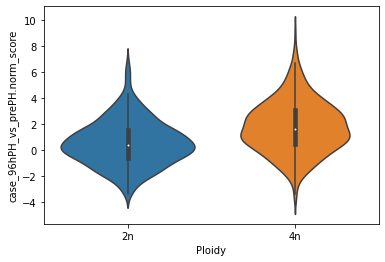

In [9]:
df_plot = dic_data_proc['richter'].obs.copy()
df_plot = df_plot.join(dic_score['richter.hm'][['case_96hPH_vs_prePH.norm_score']])
sns.violinplot(data=df_plot, x='Ploidy', y='case_96hPH_vs_prePH.norm_score')

### UMAP for all hepatocytes

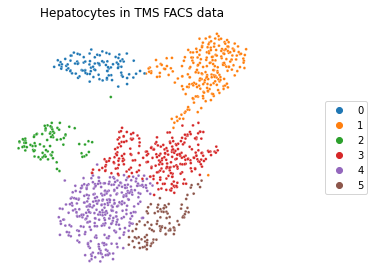

In [21]:
# Figure 
df_plot = pd.DataFrame(index=dic_data_proc['facs'].obs_names,
                       data={'UMAP1':dic_data_proc['facs'].obsm['X_umap'][:,0],
                             'UMAP2':dic_data_proc['facs'].obsm['X_umap'][:,1]})
df_plot = df_plot.join(dic_data_proc['facs'].obs['leiden'])

plt.figure(figsize=[5.5,4])
ax = plt.subplot(1,1,1)
ax.axis('off')
g = sns.scatterplot(data=df_plot, x='UMAP1', y='UMAP2', hue='leiden', s=8)
g.legend(loc='center left', bbox_to_anchor=(1.25, 0.5), ncol=1)
plt.title('Hepatocytes in TMS FACS data')
plt.tight_layout()
plt.savefig(FIG_PATH+'/hep_tms_annot_umap.svg')
plt.savefig(FIG_PATH+'/hep_tms_annot_umap.png')
plt.show()

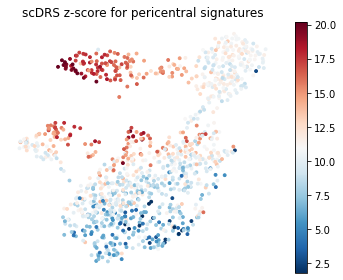

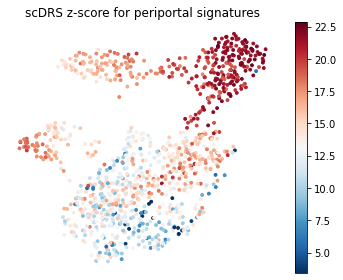

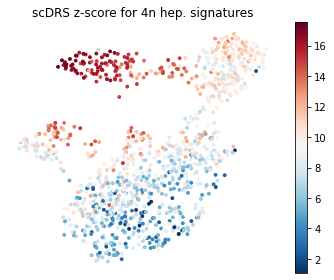

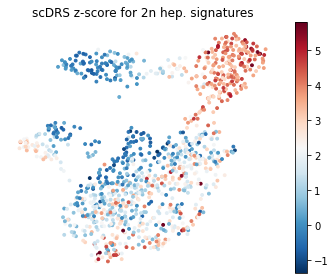

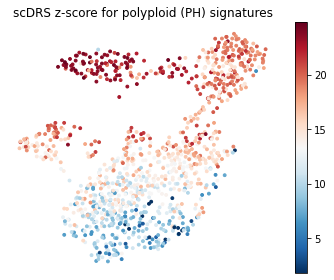

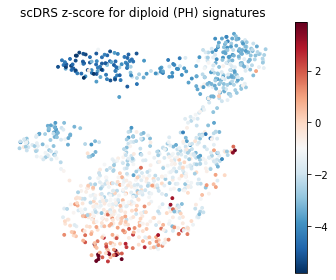

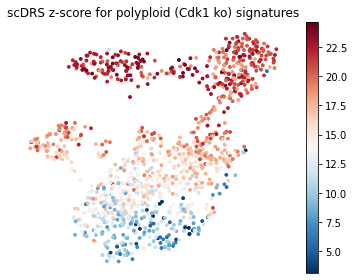

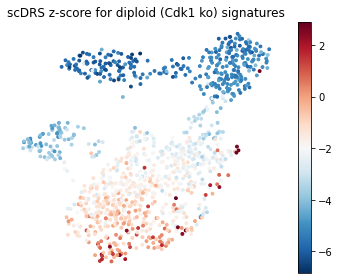

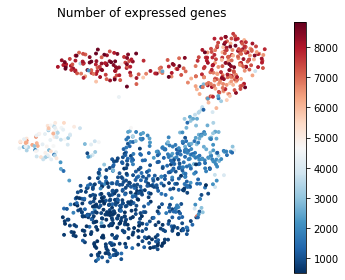

In [22]:
# UMAP for hep signatures  
ds = 'facs'
plot_list = ['CV', 'PN', 'hep4n_richter', 'hep2n_richter', 'case_96hPH_vs_prePH', 'case_prePH_vs_96hPH',
             'case_vs_ctrl_96hPH', 'ctrl_vs_case_96hPH', 'n_genes']
df_plot = pd.DataFrame(index=dic_data_proc['facs'].obs_names,
                       data={'UMAP1':dic_data_proc['facs'].obsm['X_umap'][:,0],
                             'UMAP2':dic_data_proc['facs'].obsm['X_umap'][:,1]})
df_plot = df_plot.join(dic_data_proc['facs'].obs)
df_plot = df_plot.join(dic_score['%s.hm'%ds])
df_plot = df_plot.loc[dic_cell_list[ds]]

for trait in plot_list:

    plt.figure(figsize=[5,4])
    ax = plt.subplot(1,1,1)
    ax.axis('off')
    
    term = '%s.norm_score'%trait if trait!='n_genes' else 'n_genes'
    title = 'scDRS z-score for %s signatures'%DF_TRAIT_INFO.loc[trait, 'Code'] \
        if trait!='n_genes' else 'Number of expressed genes'
    
    vmax = np.quantile(df_plot[term], 0.99) + 0.5
    vmin = np.quantile(df_plot[term], 0.01) - 0.5
    plt.scatter(df_plot['UMAP1'], df_plot['UMAP2'], c=df_plot[term],
                cmap='RdBu_r', vmin=vmin, vmax=vmax, s=8)
    plt.colorbar()
    plt.title(title)

    plt.tight_layout()
    plt.savefig(FIG_PATH+'/hepsig.%s.%s.svg'%(ds, trait))
    plt.show()

### Subpolulation of associated cells 

facs UKB_460K.biochemistry_AlanineAminotransferase


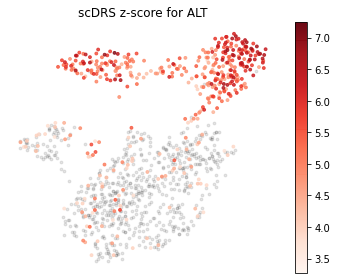

aizarani UKB_460K.biochemistry_AlanineAminotransferase


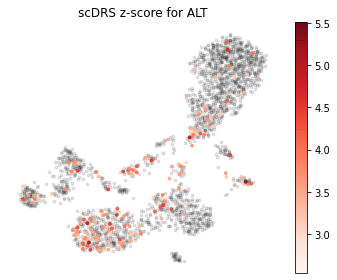

halpern UKB_460K.biochemistry_AlanineAminotransferase
richter UKB_460K.biochemistry_AlanineAminotransferase
rao UKB_460K.biochemistry_AlanineAminotransferase
facs UKB_460K.biochemistry_AlkalinePhosphatase


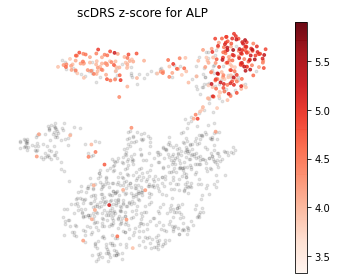

aizarani UKB_460K.biochemistry_AlkalinePhosphatase


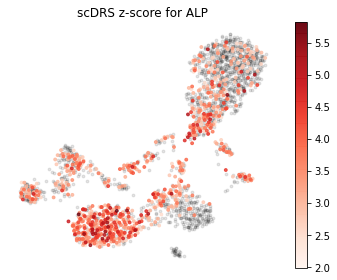

halpern UKB_460K.biochemistry_AlkalinePhosphatase
richter UKB_460K.biochemistry_AlkalinePhosphatase
rao UKB_460K.biochemistry_AlkalinePhosphatase
facs UKB_460K.biochemistry_Cholesterol


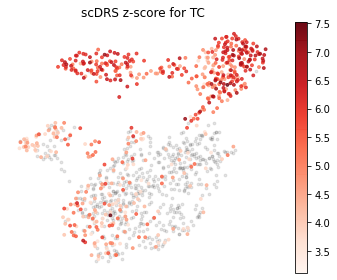

aizarani UKB_460K.biochemistry_Cholesterol


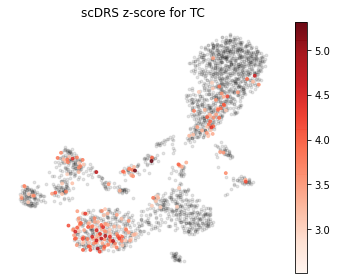

halpern UKB_460K.biochemistry_Cholesterol
richter UKB_460K.biochemistry_Cholesterol
rao UKB_460K.biochemistry_Cholesterol
facs UKB_460K.biochemistry_HDLcholesterol


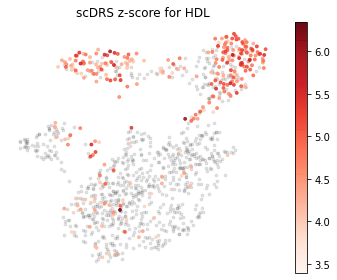

aizarani UKB_460K.biochemistry_HDLcholesterol


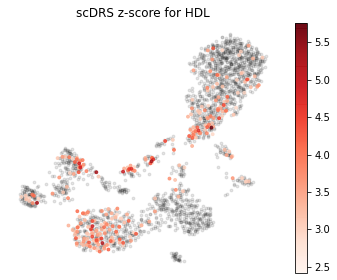

halpern UKB_460K.biochemistry_HDLcholesterol
richter UKB_460K.biochemistry_HDLcholesterol
rao UKB_460K.biochemistry_HDLcholesterol
facs UKB_460K.biochemistry_LDLdirect


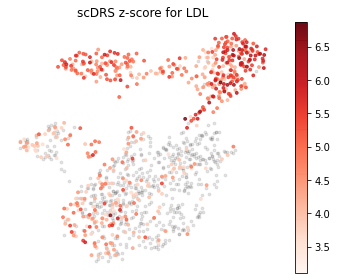

aizarani UKB_460K.biochemistry_LDLdirect


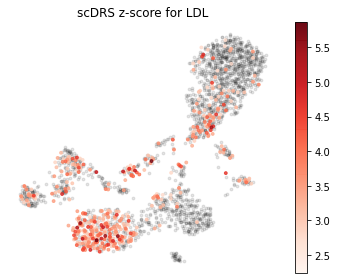

halpern UKB_460K.biochemistry_LDLdirect
richter UKB_460K.biochemistry_LDLdirect
rao UKB_460K.biochemistry_LDLdirect
facs UKB_460K.biochemistry_SHBG


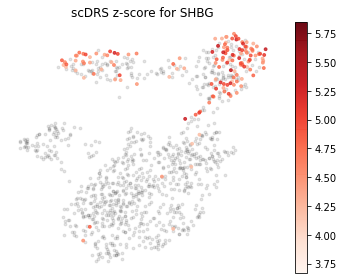

aizarani UKB_460K.biochemistry_SHBG


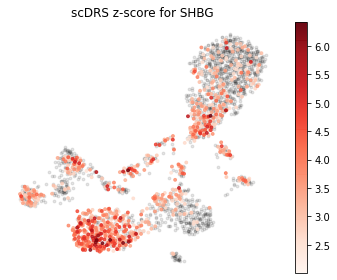

halpern UKB_460K.biochemistry_SHBG
richter UKB_460K.biochemistry_SHBG
rao UKB_460K.biochemistry_SHBG
facs UKB_460K.biochemistry_Testosterone_Male


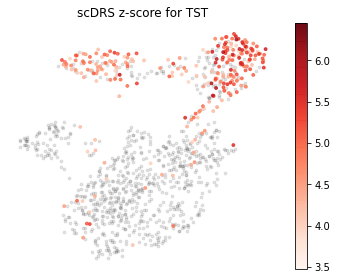

aizarani UKB_460K.biochemistry_Testosterone_Male


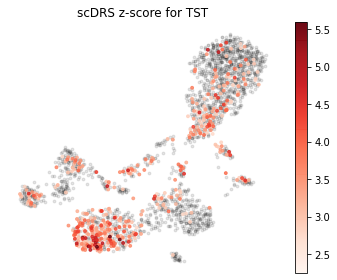

halpern UKB_460K.biochemistry_Testosterone_Male
richter UKB_460K.biochemistry_Testosterone_Male
rao UKB_460K.biochemistry_Testosterone_Male
facs UKB_460K.biochemistry_TotalBilirubin


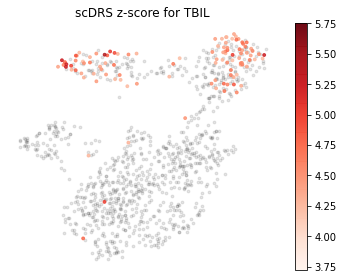

aizarani UKB_460K.biochemistry_TotalBilirubin


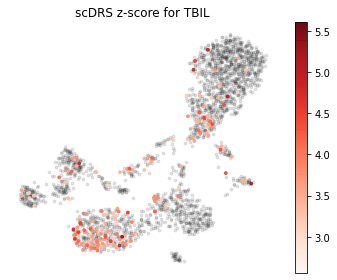

halpern UKB_460K.biochemistry_TotalBilirubin
richter UKB_460K.biochemistry_TotalBilirubin
rao UKB_460K.biochemistry_TotalBilirubin
facs UKB_460K.biochemistry_Triglycerides


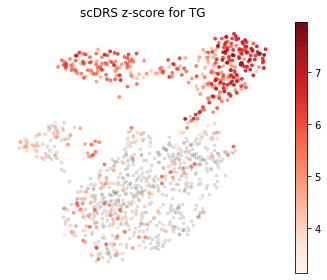

aizarani UKB_460K.biochemistry_Triglycerides


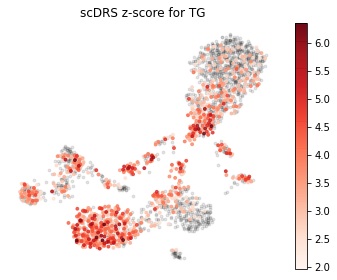

halpern UKB_460K.biochemistry_Triglycerides
richter UKB_460K.biochemistry_Triglycerides
rao UKB_460K.biochemistry_Triglycerides


In [23]:
for trait in DIC_TRAIT_LIST['facs']:
    for ds in DS_LIST:
#     for ds in ['rao']:
        print(ds, trait)
        df_plot = pd.DataFrame(index=dic_data_proc[ds].obs_names,
                               data={'UMAP1':dic_data_proc[ds].obsm['X_umap'][:,0],
                                     'UMAP2':dic_data_proc[ds].obsm['X_umap'][:,1], 
                                     'leiden_anno':dic_data_proc[ds].obs['leiden']})
        df_plot = df_plot.loc[dic_cell_list[ds]]
        df_plot = df_plot.join(dic_score[ds][['%s.fdr'%trait, '%s.nlog10_pval'%trait, '%s.norm_score'%trait]])
        df_plot.sort_values('%s.fdr'%trait, ascending=False, inplace=True)

        ind_select = df_plot['%s.fdr'%trait]<0.1
        if ind_select.sum()<10:
            continue
        
        plt.figure(figsize=[5,4])
        ax = plt.subplot(1,1,1)
        ax.axis('off')
        vmax = np.quantile(df_plot.loc[ind_select, '%s.norm_score'%trait], 0.99) + 0.5
        vmin = np.quantile(df_plot.loc[ind_select, '%s.norm_score'%trait], 0.01) - 0.5
        plt.scatter(df_plot.loc[~ind_select, 'UMAP1'], df_plot.loc[~ind_select, 'UMAP2'],
                    c='k', s=8, alpha=0.1)
        plt.scatter(df_plot.loc[ind_select, 'UMAP1'], df_plot.loc[ind_select, 'UMAP2'], 
                    c=df_plot.loc[ind_select, '%s.norm_score'%trait],
                    cmap='Reds', s=8, vmax=vmax, vmin=vmin, alpha=0.8)
        plt.colorbar()
        plt.title('scDRS z-score for %s'%DF_TRAIT_INFO.loc[trait, 'Code'])

        plt.tight_layout()
        plt.savefig(FIG_PATH+'/sctrs_assoc.%s.%s.svg'%(ds, trait))
        plt.show()

### Annotation for TG associated cells 

... storing 'tissue_celltype' as categorical
... storing 'leiden_sig' as categorical


# Removed: Hsl
# Removed: Dgat


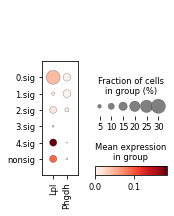

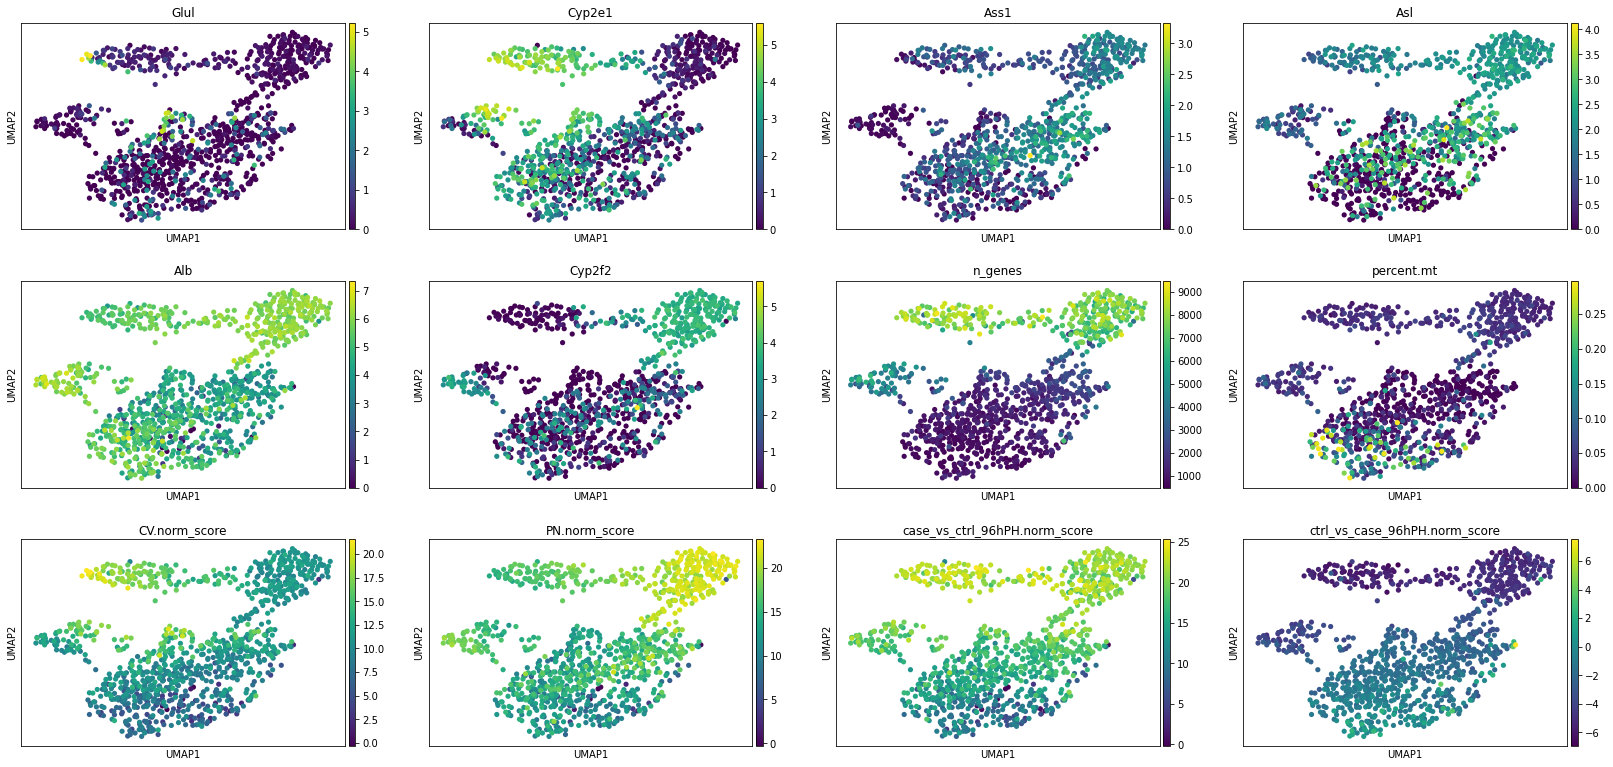

In [24]:
# trait = 'UKB_460K.biochemistry_LDLdirect'
trait = 'UKB_460K.biochemistry_Triglycerides'
ds = 'facs'

# Assign sig label for each leiden cluster (remove sig cells in small clusters)
adata = dic_data_raw[ds][dic_cell_list[ds], :].copy()
temp_adata = dic_data_proc[ds][dic_cell_list[ds], :].copy()
adata.obs = adata.obs.join(temp_adata.obs[[x for x in temp_adata.obs.columns if x not in adata.obs.columns]])
adata.obsm = temp_adata.obsm

adata.obs = adata.obs.join(dic_score[ds]['%s.fdr'%trait])
adata.obs['leiden_sig'] = ['%s.sig'%x if y<0.1 else 'nonsig'
                           for x,y in zip(adata.obs['leiden'], adata.obs['%s.fdr'%trait])]

temp_df = adata.obs.groupby(['leiden_sig']).agg({'cell':len})
cluster_remove_list = list(temp_df.index[temp_df['cell']<25])
adata.obs.loc[adata.obs['leiden_sig'].isin(cluster_remove_list), 'leiden_sig'] = 'nonsig' 

# Specifically expressed genes 
group_list = sorted([x for x in adata.obs['leiden_sig'].unique() if '.sig' in x])
# sc.tl.rank_genes_groups(adata, groupby='leiden_sig', reference='rest', groups=group_list+['nonsig'])
# sc.pl.rank_genes_groups(adata, fontsize=10, ncols=2, n_genes=25)

# Marker gene expression 
marker_list = ['Lpl', 'Hsl', 'Dgat', 'Phgdh', # TG regulation
#                'Vldlr', 'Ldlr', 'Lrp1', 'Scarb1', 'Srebf2', 'Scap', 'Pcsk9', 'Sar1b', 'Itgav', 
#                'Adipoq', 'App', 'Itgb3', 'Psen1', 'Hnrnpk', 'Anxa2', 'Pparg', 'Cnpy2', # Lipoprotein receptor
#                'Alb', # Plasma protein secretion
#                'Fgb', 'F2', 'F9', 'Kng1', 'Aplp2', # Blood clotting factors 
#                'Gc', # Vitamin D
#                'G6pc', # Glycogenolysis and gluconeogenesis
#                'Cyp', 'Glul', 'Oat', 'Ces3a', 'Slc22a1', 'Aldh3a2', # Detoxification
#                'Akr1c6', 'Abcb4', # Bile acid synthesis
#                'Blvrb', # Heme synthesis
#                'Csad', # Amino acid metabolism
#                'Rgn', # Calcium homeostasis
#                'Hmgcl', # Ketogenesis
#                'Stard10', 'Apoa', 'Apoc', # Hormone, vitamin, and lipid transport
#                'Hmgcs2', 'Aldh2', 'Ppara', 'MGll', # Cholesterol, alcohol and lipid metabolism
#                'Agt', 'Igfbp2', 'Igfbp4', # Hormone synthesis and secretion
#                'Hamp', 'Ftl1', 'Hp', # Iron homeostasis and storage
#                'Ass1', 'Asl', # Urea synthesis from ammonia 
#                'Gpx1', # Glutathione synthesis 
#                'Pck1', 'Fbp1', # Gluconeogenesis
#                'Arg1', # Urea synthesis from arginine
#                'Cat', # Catalase production
#                'Cox', 'Nduf' # Respiration (b-oxidation)
#                'Glul', 'Apoe', 'Cyp1a2', 'Cyp2e1', 'Cyp2f2', 'Cyp2e1', # Central
#                'Arg1', 'Alb', 'Pck1' # Periportal
              ]
for gene in marker_list.copy():
    if gene not in adata.var_names:
        marker_list.remove(gene)
        print('# Removed: %s'%gene)
sc.pl.dotplot(adata, marker_list, groupby='leiden_sig')

# Zonation markers
marker_list = ['Glul', 'Cyp2e1', 'Ass1', 'Asl', 'Alb', 'Cyp2f2',
               'n_genes', 'percent.mt', 'CV.norm_score', 'PN.norm_score',
               'case_vs_ctrl_96hPH.norm_score', 'ctrl_vs_case_96hPH.norm_score']
adata.obs = adata.obs.join(dic_score['facs.hm'][['CV.norm_score', 'PN.norm_score',
                                                 'case_vs_ctrl_96hPH.norm_score', 'ctrl_vs_case_96hPH.norm_score']])
sc.pl.umap(adata, color=marker_list)

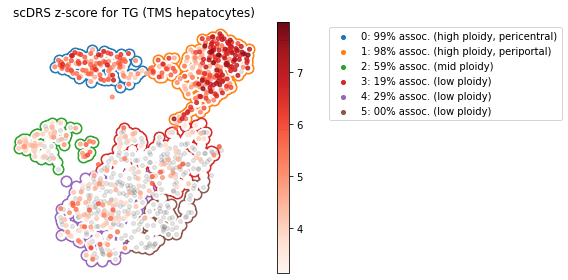

In [25]:
# UMAP plot with annotations 
ds='facs'
group_list = sorted([x for x in adata.obs['leiden_sig'].unique() if '.sig' in x])
dic_config = {'0': ['C0', '0: @p (high ploidy, pericentral)'],
              '1': ['C1', '1: @p (high ploidy, periportal)'],
              '2': ['C2', '2: @p (mid ploidy)'], 
              '3': ['C3', '3: @p (low ploidy)'], 
              '4': ['C4', '4: @p (low ploidy)'],
              '5': ['C5', '5: @p (low ploidy)']
             }

# Get df_plot 
df_plot = pd.DataFrame(index=adata.obs_names,
                       data={'UMAP1':adata.obsm['X_umap'][:,0],
                             'UMAP2':adata.obsm['X_umap'][:,1]})
df_plot = df_plot.join(adata.obs[['leiden', 'leiden_sig']])
df_plot = df_plot.loc[dic_cell_list[ds]]
df_plot = df_plot.join(dic_score[ds][['%s.fdr'%trait, '%s.nlog10_pval'%trait, '%s.norm_score'%trait]])
df_plot.sort_values('%s.fdr'%trait, ascending=False, inplace=True)

# Figure 
plt.figure(figsize=[8,4])
ax = plt.subplot(1,1,1)
ax.axis('off')

# Cluster boundry 
x_range = df_plot['UMAP1'].max()-df_plot['UMAP1'].min()
y_range = df_plot['UMAP2'].max()-df_plot['UMAP2'].min()
for cluster in dic_config:
    ind_select = df_plot['leiden']==cluster
    n_sig,n_tot = (df_plot['leiden_sig']=='%s.sig'%cluster).sum(),ind_select.sum()
    temp_df = df_plot.loc[ind_select, ['UMAP1', 'UMAP2']].copy()
    xmin = np.quantile(temp_df['UMAP1'], 0.05)-0.05*x_range,
    xmax = np.quantile(temp_df['UMAP1'], 0.95)+0.05*x_range
    ymin = np.quantile(temp_df['UMAP2'], 0.05)-0.05*y_range,
    ymax = np.quantile(temp_df['UMAP2'], 0.95)+0.05*y_range
    ind_select = (temp_df['UMAP1']>xmin) & (temp_df['UMAP1']<xmax) & \
                    (temp_df['UMAP2']>ymin) & (temp_df['UMAP2']<ymax)
    plt.scatter(temp_df.loc[ind_select, 'UMAP1'][:2], temp_df.loc[ind_select, 'UMAP2'][:2],
                s=16, color=dic_config[cluster][0], 
                label=dic_config[cluster][1].replace('@p', '%02d%% assoc.'%(n_sig/n_tot*100)), 
                zorder=0)
    plt.scatter(temp_df.loc[ind_select, 'UMAP1'], temp_df.loc[ind_select, 'UMAP2'],
                s=120, color=dic_config[cluster][0], zorder=1)
    plt.scatter(temp_df.loc[ind_select, 'UMAP1'], temp_df.loc[ind_select, 'UMAP2'],
                s=60, color='w', zorder=2)

ind_select_sig = (df_plot['leiden_sig']!='nonsig')
np.random.seed(0)
cell_list_nonsig = np.random.choice(df_plot.index[~ind_select_sig], 
                                    size=int((~ind_select_sig).sum()*0.5), replace=False)
plt.scatter(df_plot.loc[cell_list_nonsig, 'UMAP1'], df_plot.loc[cell_list_nonsig, 'UMAP2'],
                c='k', s=16, alpha=0.1, zorder=5)

vmax = np.quantile(df_plot.loc[ind_select_sig, '%s.norm_score'%trait], 0.99) + 0.5
vmin = np.quantile(df_plot.loc[ind_select_sig, '%s.norm_score'%trait], 0.01) - 0.5
plt.scatter(df_plot.loc[ind_select_sig, 'UMAP1'], df_plot.loc[ind_select_sig, 'UMAP2'], 
            c=df_plot.loc[ind_select_sig, '%s.norm_score'%trait],
            cmap='Reds', s=16, vmax=vmax, vmin=vmin, alpha=0.8, zorder=10)
plt.colorbar()
plt.legend(bbox_to_anchor=(1.25, 1), loc='upper left')
plt.title('scDRS z-score for %s (TMS hepatocytes)'%DF_TRAIT_INFO.loc[trait, 'Code'])
plt.tight_layout()
plt.savefig(FIG_PATH+'/sctrs_assoc.annot_%s_umap.svg'%DF_TRAIT_INFO.loc[trait, 'Code'])
plt.savefig(FIG_PATH+'/sctrs_assoc.annot_%s_umap.png'%DF_TRAIT_INFO.loc[trait, 'Code'])
plt.show()

### Joint regression analysis based on covariates 

In [7]:
# Validate ploidy score
for ploidy_term in ['hep4n_richter', 'case_96hPH_vs_prePH', 'case_vs_ctrl_96hPH', 'large_vs_small', 
                    'hep2n_richter', 'case_prePH_vs_96hPH', 'ctrl_vs_case_96hPH']:
    df_reg = dic_data_proc['richter'].obs.copy()
    df_reg['ploidy'] = (df_reg['Ploidy']=='4n')*1
    df_reg = df_reg.join(dic_score['richter.hm'][['%s.norm_score'%ploidy_term]])
    df_reg = df_reg.join(dic_ctrl_score['richter.hm'][ploidy_term])

    corr_ = np.corrcoef(df_reg['ploidy'], df_reg['%s.norm_score'%ploidy_term])[0,1]
    v_corr_ = np.zeros(500) 
    for i in range(500):
        v_corr_[i] = np.corrcoef(df_reg['ploidy'], df_reg['ctrl_norm_score_%d'%i])[0,1]
    if ploidy_term in ['hep4n_richter', 'case_96hPH_vs_prePH', 'case_vs_ctrl_96hPH', 'large_vs_small']:
        p_=((corr_ <= v_corr_).sum()+1) / 501
    else:
        p_=((corr_ >= v_corr_).sum()+1) / 501
    print('# Richter Ploidy and %-20s: Corr.=%0.2f P=%0.3f'%(ploidy_term, corr_, p_))
print('')

# Validate CV/PN score
for comparison_term in [['CV', 'Layer 1'], ['PN', 'Layer 9']]:
    term,annot = comparison_term
    df_reg = dic_data_proc['halpern'].obs.copy()
    df_reg = df_reg.join(dic_score['halpern.hm'][['%s.norm_score'%term]])
    df_reg = df_reg.join(dic_ctrl_score['halpern.hm'][term])
    corr_ = np.corrcoef(df_reg[annot], df_reg['%s.norm_score'%term])[0,1]
    v_corr_ = np.zeros(500) 
    for i in range(500):
        v_corr_[i] = np.corrcoef(df_reg[annot], df_reg['ctrl_norm_score_%d'%i])[0,1]
        p_=((corr_ <= v_corr_).sum()+1) / 501
    print('# Halpern %s and %-20s: Corr.=%0.2f P=%0.3f'%(annot, term, corr_, p_))
print('')
    
for term in ['CV', 'PN']:
    df_reg = dic_data_proc['aizarani'].obs.copy()
    df_reg = df_reg.join(dic_score['aizarani.hm'][['%s.norm_score'%term]])
    df_reg = df_reg.join(dic_ctrl_score['aizarani.hm'][term])
    corr_ = np.corrcoef(df_reg['zonation'], df_reg['%s.norm_score'%term])[0,1]
    v_corr_ = np.zeros(500) 
    for i in range(500):
        v_corr_[i] = np.corrcoef(df_reg['zonation'], df_reg['ctrl_norm_score_%d'%i])[0,1]
        p_=((corr_ <= v_corr_).sum()+1) / 501
    print('# Aizarani zonation and %-20s: Corr.=%0.2f P=%0.3f'%(term, corr_, p_))

# Richter Ploidy and hep4n_richter       : Corr.=0.48 P=0.002
# Richter Ploidy and case_96hPH_vs_prePH : Corr.=0.28 P=0.002
# Richter Ploidy and case_vs_ctrl_96hPH  : Corr.=0.20 P=0.002
# Richter Ploidy and large_vs_small      : Corr.=0.25 P=0.002
# Richter Ploidy and hep2n_richter       : Corr.=-0.59 P=0.002
# Richter Ploidy and case_prePH_vs_96hPH : Corr.=-0.20 P=0.002
# Richter Ploidy and ctrl_vs_case_96hPH  : Corr.=-0.15 P=0.002

# Halpern Layer 1 and CV                  : Corr.=0.43 P=0.002
# Halpern Layer 9 and PN                  : Corr.=0.45 P=0.002

# Aizarani zonation and CV                  : Corr.=-0.13 P=0.880
# Aizarani zonation and PN                  : Corr.=0.12 P=0.174


In [8]:
# Prepare regression datasets 
dic_cov = {}
ploidy_term = 'case_96hPH_vs_prePH'

# FACS all 
dic_cov['facs'] = dic_data_proc['facs'].obs.copy()
dic_cov['facs']['ploidy'] = dic_score['facs.hm'].loc[dic_cov['facs'].index, '%s.norm_score'%ploidy_term]
dic_cov['facs']['CV'] = dic_score['facs.hm'].loc[dic_cov['facs'].index, 'CV.norm_score']
dic_cov['facs']['PN'] = dic_score['facs.hm'].loc[dic_cov['facs'].index, 'PN.norm_score']

# droplet 
dic_cov['droplet'] = dic_data_proc['droplet'].obs.copy()
dic_cov['droplet']['ploidy'] = dic_score['droplet.hm'].loc[dic_cov['droplet'].index, '%s.norm_score'%ploidy_term]
dic_cov['droplet']['CV'] = dic_score['droplet.hm'].loc[dic_cov['droplet'].index, 'CV.norm_score']
dic_cov['droplet']['PN'] = dic_score['droplet.hm'].loc[dic_cov['droplet'].index, 'PN.norm_score']

# aizarani
dic_cov['aizarani'] = dic_data_proc['aizarani'].obs.copy()
dic_cov['aizarani']['ploidy'] = dic_score['aizarani.hm'].loc[dic_cov['aizarani'].index, '%s.norm_score'%ploidy_term]
dic_cov['aizarani']['CV'] = dic_score['aizarani.hm'].loc[dic_cov['aizarani'].index, 'CV.norm_score']
dic_cov['aizarani']['PN'] = dic_score['aizarani.hm'].loc[dic_cov['aizarani'].index, 'PN.norm_score']

# halpern
dic_cov['halpern'] = dic_data_proc['halpern'].obs.copy()
dic_cov['halpern']['ploidy'] = dic_score['halpern.hm'].loc[dic_cov['halpern'].index, '%s.norm_score'%ploidy_term]
dic_cov['halpern']['CV'] = dic_score['halpern.hm'].loc[dic_cov['halpern'].index, 'CV.norm_score']
dic_cov['halpern']['PN'] = dic_score['halpern.hm'].loc[dic_cov['halpern'].index, 'PN.norm_score']

# richter
dic_cov['richter'] = dic_data_proc['richter'].obs.copy()
dic_cov['richter']['gt_ploidy'] = (dic_cov['richter']['Ploidy']=='4n')*1
dic_cov['richter']['ploidy'] = dic_score['richter.hm'].loc[dic_cov['richter'].index, '%s.norm_score'%ploidy_term]
dic_cov['richter']['CV'] = dic_score['richter.hm'].loc[dic_cov['richter'].index, 'CV.norm_score']
dic_cov['richter']['PN'] = dic_score['richter.hm'].loc[dic_cov['richter'].index, 'PN.norm_score']

# # richter_Ploidy
# dic_cov['richter_Ploidy'] = dic_data_proc['richter'].obs.copy()
# dic_cov['richter_Ploidy']['ploidy'] = (dic_cov['richter_Ploidy']['Ploidy']=='4n')*1
# dic_cov['richter_Ploidy']['CV'] = dic_score['richter.hm'].loc[dic_cov['richter_Ploidy'].index, 'CV.norm_score']
# dic_cov['richter_Ploidy']['PN'] = dic_score['richter.hm'].loc[dic_cov['richter_Ploidy'].index, 'PN.norm_score']

# rao
dic_cov['rao'] = dic_data_proc['rao'].obs.copy()
dic_cov['rao']['ploidy'] = dic_score['rao.hm'].loc[dic_cov['rao'].index, '%s.norm_score'%ploidy_term]
dic_cov['rao']['CV'] = dic_score['rao.hm'].loc[dic_cov['rao'].index, 'CV.norm_score']
dic_cov['rao']['PN'] = dic_score['rao.hm'].loc[dic_cov['rao'].index, 'PN.norm_score']

# Add const and leiden
for cov_name in dic_cov:
    dic_cov[cov_name]['const'] = 1
    for cluster in set(dic_cov[cov_name]['leiden']):
        dic_cov[cov_name]['leidenreg_%s'%cluster] = (dic_cov[cov_name]['leiden']==cluster)*1
    
# Regout 
for cov_name in dic_cov:
    mat_Y = np.ones([dic_cov[cov_name].shape[0],2])
    mat_Y[:,1] = dic_cov[cov_name]['ploidy']
    dic_cov[cov_name]['CV'] = md.reg_out(dic_cov[cov_name]['CV'], mat_Y)
    dic_cov[cov_name]['PN'] = md.reg_out(dic_cov[cov_name]['PN'], mat_Y)

In [9]:
# Joint regression analysis
def p_2_str(p_):
    if p_>0.05:
        return ''
    elif p_>0.01:
        return '*'
    elif p_>0.005:
        return '**'
    else: 
        return '***'
    
def p_2_str_num(p_):
    if p_>1/500.5:
        return 'P=%0.3f'%p_
    else:
        return 'P<0.002'
    
dic_reg = {'reg_joint': ['ploidy', 'CV', 'PN'],
           # 'reg_ploidy': ['ploidy'],
           # 'reg_cvpn': ['CV', 'PN']
          }
trait_black_list = ['CV', 'PN', ploidy_term]

dic_stats = {}
for cov_name in dic_cov:
    ctrl_list = ['const'] + [x for x in dic_cov[cov_name].columns if 'leidenreg' in x]
    for reg_name in dic_reg:
        print(cov_name, reg_name)
        reg_list = dic_reg[reg_name]
        df_stats = pd.DataFrame(columns=['var_ctrl','var']+['%s.%s'%(y,x) for x in reg_list for y in ['T', 'P']])
        ds = cov_name.split('_' )[0]
        
        for score in [ds, ds+'.hm']:
            for trait in DIC_TRAIT_LIST[score]:
                if '%s.norm_score'%trait not in dic_score[score]:
                    continue
                if trait in trait_black_list:
                    continue                

                df_reg = dic_cov[cov_name][reg_list+ctrl_list].copy()
                df_reg = df_reg.join(dic_score[score][['%s.norm_score'%trait]])
                df_reg = df_reg.join(dic_ctrl_score[score][trait])
                
                res = sm.OLS(df_reg['%s.norm_score'%trait], df_reg[ctrl_list]).fit()
                var_explain_ctrl_ = 1 - res.mse_resid/res.mse_total

                res = sm.OLS(df_reg['%s.norm_score'%trait], df_reg[ctrl_list+reg_list]).fit()
                var_explain_ = 1 - res.mse_resid/res.mse_total
                dic_t = {x:res.tvalues[x] for x in reg_list}
                dic_t_ctrl = {x:np.zeros(500) for x in reg_list}

                for i in range(500):
                    res = sm.OLS(df_reg['ctrl_norm_score_%d'%i], df_reg[ctrl_list+reg_list]).fit()
                    for reg in reg_list:
                        dic_t_ctrl[reg][i] = res.tvalues[reg]

                dic_p = {x:((dic_t[x] <= dic_t_ctrl[x]).sum()+1) / 501 for x in reg_list} 
                df_stats.loc[trait] = [var_explain_ctrl_, var_explain_] + \
                    [y[x] for x in reg_list for y in [dic_t, dic_p]]

        for reg_term in reg_list:
            df_stats['P_STR.%s'%reg_term] = [p_2_str(x) for x in df_stats['P.%s'%reg_term]]
            df_stats['P_STR_NUM.%s'%reg_term] = [p_2_str_num(x) for x in df_stats['P.%s'%reg_term]]
        dic_stats['%s.%s'%(cov_name, reg_name)] = df_stats

facs reg_joint
droplet reg_joint
aizarani reg_joint
halpern reg_joint
richter reg_joint
rao reg_joint


In [22]:
DIC_TRAIT_LIST['facs']

['UKB_460K.biochemistry_AlanineAminotransferase',
 'UKB_460K.biochemistry_AlkalinePhosphatase',
 'UKB_460K.biochemistry_Cholesterol',
 'UKB_460K.biochemistry_HDLcholesterol',
 'UKB_460K.biochemistry_LDLdirect',
 'UKB_460K.biochemistry_SHBG',
 'UKB_460K.biochemistry_Testosterone_Male',
 'UKB_460K.biochemistry_TotalBilirubin',
 'UKB_460K.biochemistry_Triglycerides']

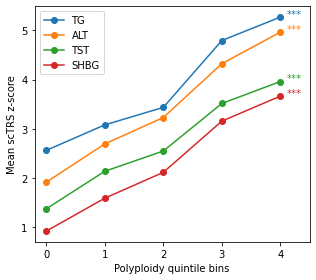

In [28]:
# Ploidy results for FACs GWAS traits
trait_list = ['UKB_460K.biochemistry_AlanineAminotransferase',
             'UKB_460K.biochemistry_SHBG',
             'UKB_460K.biochemistry_Testosterone_Male',
             'UKB_460K.biochemistry_Triglycerides']
df_plot = dic_cov['facs'][['ploidy']].copy()
df_plot = df_plot.join(dic_score['facs'][['%s.norm_score'%x for x in trait_list]])
df_plot['bin'] = pd.qcut(df_plot['ploidy'], q=5, labels=False)

# Reorder traits 
cell_list = df_plot.index[df_plot['ploidy']>np.quantile(df_plot['ploidy'], 0.8)]
temp_df = pd.DataFrame(index=trait_list,
                       data={'score': [dic_score['facs'].loc[cell_list, '%s.norm_score'%x].mean()
                                       for x in trait_list]})
temp_df.sort_values(by='score', ascending=False, inplace=True)
trait_list = list(temp_df.index)

i_color = 0
y_text = 8
plt.figure(figsize=[4.5,4])
for i_trait,trait in enumerate(trait_list):

    temp_df = df_plot.groupby('bin').agg({'%s.norm_score'%trait: np.mean})
    temp_df.columns = ['mean']
    plt.plot(temp_df.index, temp_df['mean'], 'o-', label=DF_TRAIT_INFO.loc[trait, 'Code'], 
             color='C%d'%i_color)
    y_text = min(y_text-0.1, temp_df['mean'][4])
    plt.text(4.1, y_text, dic_stats['facs.reg_joint'].loc[trait,'P_STR.ploidy'], color='C%d'%i_color)
    i_color += 1

plt.xlim([-0.2,4.5])
plt.legend()
plt.xlabel('Polyploidy quintile bins')
plt.ylabel('Mean scTRS z-score')
plt.tight_layout()
plt.savefig(FIG_PATH+'/hepreg.ploidy.facs.svg')
plt.show()

In [ ]:
# T cell signatures
adata = dic_data_proc['facs'].copy()
plot_list = [['dpt_cd4_qn', ['naive_cd4', 'memory_cd4', 'effector_cd4', 'reg_cd4']],
             ['dpt_cd8_qn', ['naive_cd8', 'memory_cd8', 'effector_cd8']] ]

ds = 'facs_tsig'

for temp_list in plot_list:
    term,sig_list = temp_list
    df_plot = adata.obs[[term]].copy()
    df_plot = df_plot.loc[df_plot[term]>0]
    df_plot = df_plot.join(dic_score[ds].loc[adata.obs_names, ['%s.norm_score'%x for x in sig_list]])
    df_plot['bin'] = pd.qcut(df_plot[term], q=5, labels=False)
    
    plt.figure(figsize=[5.5,4])
    i_color = 0
    for sig in sig_list:
        temp_df = df_plot.groupby('bin').agg({'%s.norm_score'%sig: np.mean})
        plt.plot(temp_df.index, temp_df['%s.norm_score'%sig], 'o-', label=DF_TRAIT_INFO.loc[sig, 'Code'],
                 color='C%d'%i_color)
        plt.text(4.2, temp_df['%s.norm_score'%sig][4], df_stats.loc['%s.%s'%(term,sig),'P_STR'],
                 color='C%d'%i_color)
        i_color+=1
    
    plt.xlim([-0.5,4.8])
    plt.legend(bbox_to_anchor=[1,1], loc='upper left')
    plt.xlabel('%s quintile bins'%dic_title[term])
    plt.ylabel('Mean scTRS score')
    plt.title(dic_title[term])
    plt.tight_layout()
    plt.savefig(FIG_PATH+'/dpt_tsig_corr.%s.svg'%term)
    plt.show()
    

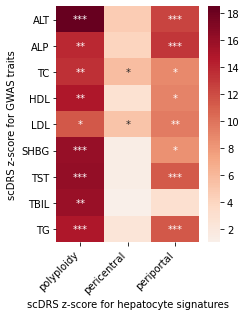

In [163]:
# Joint results for FACs GWAS traits
reg_name = 'reg_joint'
trait_list = DIC_TRAIT_LIST['facs']
ds ='facs'
dic_name = {'ploidy':'polyploidy', 'CV':'pericentral', 'PN':'periportal'}

df_plot = dic_stats['%s.%s'%(ds,reg_name)].loc[trait_list, ['T.%s'%x for x in dic_reg[reg_name]]]
df_plot_annot = dic_stats['%s.%s'%(ds,reg_name)].loc[trait_list, ['P_STR.%s'%x for x in dic_reg[reg_name]]]
df_plot.index = [DF_TRAIT_INFO.loc[x,'Code'] if x in DF_TRAIT_INFO.index else x for x in df_plot.index]
df_plot_annot.index = [DF_TRAIT_INFO.loc[x,'Code'] if x in DF_TRAIT_INFO.index else x 
                       for x in df_plot_annot.index]
df_plot.fillna(0, inplace=True)
df_plot.clip(upper=100, inplace=True)
df_plot_annot.fillna('N/A', inplace=True)

plt.figure(figsize=[3.5, 4.5])
sns.heatmap(df_plot, annot=df_plot_annot, fmt='s', cmap='RdBu_r', center=0)
plt.xticks(np.arange(df_plot.shape[1])+0.5, [dic_name[x.split('.')[1]] for x in df_plot.columns], 
           rotation=45, ha='right')
plt.yticks(np.arange(df_plot.shape[0])+0.5, df_plot.index)
plt.xlabel('scDRS z-score for hepatocyte signatures')
plt.ylabel('scDRS z-score for GWAS traits')
plt.tight_layout()
plt.savefig(FIG_PATH+'/hepreg.facs.svg')
plt.show()

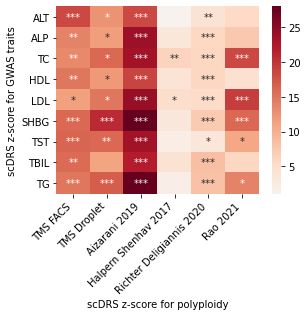

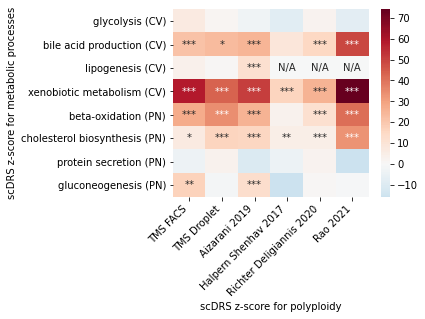

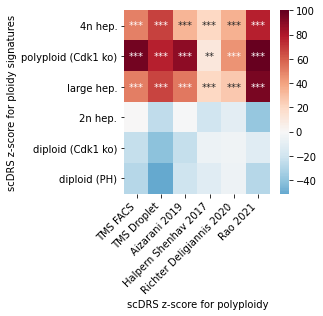

In [12]:
# Ploidy score all data
ds_list = DS_LIST
dic_plot_trait = {'GWAS traits': DIC_TRAIT_LIST['facs'], 
                  'metabolic processes': ['Glycolysis', 'Bile acid production', 'Lipogenesis',
                                           'Xenobiotic metabolism', 'Beta-oxidation', 'Cholesterol biosynthesis', 
                                           'Protein secretion', 'Gluconeogenesis'], 
                  'ploidy signatures': ['hep4n_richter', 'case_vs_ctrl_96hPH', 'large_vs_small',
                                        'hep2n_richter', 'ctrl_vs_case_96hPH', 'case_prePH_vs_96hPH', ]}
for trait_name in dic_plot_trait:
    trait_list = dic_plot_trait[trait_name]
    df_plot = pd.DataFrame(index=trait_list, columns=ds_list, dtype=float)
    df_plot_annot = pd.DataFrame(index=trait_list, columns=ds_list)
    for ds in ds_list:
        temp_list = list(set(df_plot[ds].index) & set(dic_stats['%s.reg_joint'%ds].index))
        df_plot.loc[temp_list, ds] = dic_stats['%s.reg_joint'%ds].loc[temp_list, 'T.ploidy']
        df_plot_annot.loc[temp_list, ds] = dic_stats['%s.reg_joint'%ds].loc[temp_list, 'P_STR.ploidy']

    df_plot.index = [DF_TRAIT_INFO.loc[x,'Code'] if x in DF_TRAIT_INFO.index else x for x in df_plot.index]
    df_plot_annot.index = [DF_TRAIT_INFO.loc[x,'Code'] if x in DF_TRAIT_INFO.index else x 
                           for x in df_plot_annot.index]
    df_plot.fillna(0, inplace=True)
    df_plot.clip(upper=100, inplace=True)
    df_plot_annot.fillna('N/A', inplace=True)

    plt.figure(figsize=[4.5+1.5*(trait_name=='metabolic processes'), 4.5])
    sns.heatmap(df_plot, annot=df_plot_annot, fmt='s', cmap='RdBu_r', center=0)
    plt.xticks(np.arange(df_plot.shape[1])+0.5, [DIC_INFO[x]['dname'] for x in df_plot.columns], 
               rotation=45, ha='right')
    plt.yticks(np.arange(df_plot.shape[0])+0.5, df_plot.index)
    plt.xlabel('scDRS z-score for polyploidy')
    plt.ylabel('scDRS z-score for %s'%trait_name)
    plt.tight_layout()
    plt.savefig(FIG_PATH+'/hepreg.ploidy.%s.svg'%trait_name)
    plt.show()

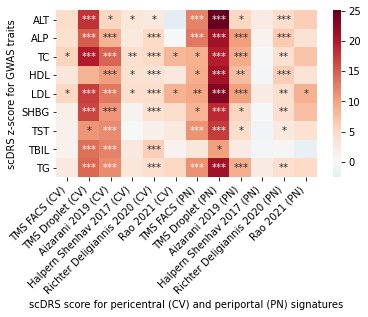

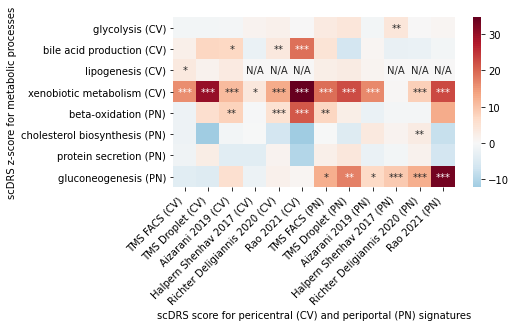

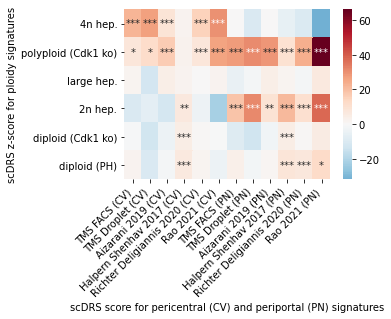

In [18]:
# CV/PN all data
ds_list = DS_LIST

for trait_name in dic_plot_trait:
    trait_list = dic_plot_trait[trait_name]
    col_list = ['%s.%s'%(x,y) for x in ['CV','PN'] for y in ds_list]
    df_plot = pd.DataFrame(index=trait_list, columns=col_list, dtype=float)
    df_plot_annot = pd.DataFrame(index=trait_list, columns=col_list)
    for col in col_list:
        hm,ds = col.split('.')
        temp_list = list(set(df_plot[col].index) & set(dic_stats['%s.reg_joint'%ds].index))
        df_plot.loc[temp_list, col] = dic_stats['%s.reg_joint'%ds].loc[temp_list, 'T.%s'%hm]
        df_plot_annot.loc[temp_list, col] = dic_stats['%s.reg_joint'%ds].loc[temp_list, 'P_STR.%s'%hm]

    df_plot.index = [DF_TRAIT_INFO.loc[x,'Code'] if x in DF_TRAIT_INFO.index else x for x in df_plot.index]
    df_plot_annot.index = [DF_TRAIT_INFO.loc[x,'Code'] if x in DF_TRAIT_INFO.index else x 
                           for x in df_plot_annot.index]
    df_plot.fillna(0, inplace=True)
    df_plot_annot.fillna('N/A', inplace=True)

    plt.figure(figsize=[5.5+2*(trait_name=='metabolic processes'), 4.5])
    sns.heatmap(df_plot, annot=df_plot_annot, fmt='s', cmap='RdBu_r', center=0)
    plt.xticks(np.arange(df_plot.shape[1])+0.5, [DIC_INFO[x.split('.')[1]]['dname'] + ' (%s)'%x.split('.')[0]
                                                 for x in df_plot.columns], 
               rotation=45, ha='right')
    plt.yticks(np.arange(df_plot.shape[0])+0.5, df_plot.index)
    plt.xlabel('scDRS score for pericentral (CV) and periportal (PN) signatures')
    plt.ylabel('scDRS z-score for %s'%trait_name)  
    plt.tight_layout()
    plt.savefig(FIG_PATH+'/hepreg.cvpn.%s.svg'%trait_name)
    plt.show()
#     break

### Old code 

### Prioritize gene sets 

In [52]:
df_gs_gwas = pd.read_csv(GS_FILE, sep='\t', index_col=0)
df_hom = pd.read_csv(DATA_PATH + '/gene_annotation/mouse_human_homologs.txt', sep='\t')
dic_map = {x:y for x,y in zip(df_hom['HUMAN_GENE_SYM'], df_hom['MOUSE_GENE_SYM'])}
background_set = set(dic_data_raw['facs'].var_names) & set(dic_map.values())

In [54]:
# Hep specific genes 
temp_adata = dic_data_raw['facs'][:, list(background_set)].copy()
temp_adata.obs['hep'] = 'nh'
temp_adata.obs.loc[dic_data_proc['facs'].obs_names, 'hep'] = 'h'
sc.tl.rank_genes_groups(temp_adata, groupby='hep', groups=['h'])
df_h = sc.get.rank_genes_groups_df(temp_adata, 'h')

... storing 'tissue_celltype' as categorical
... storing 'hep' as categorical


In [87]:
# GWAS and scTRS gene sets 
dic_gs = {}

for trait in DIC_TRAIT_LIST['facs']:
    
    # GWAS gene set
    dic_gs['%s.gwas'%trait] = set([dic_map[x] for x in df_gs_gwas.loc[trait, 'GENESET'].split(',') if x in dic_map])
    dic_gs['%s.gwas'%trait] = dic_gs['%s.gwas'%trait] & background_set
    
    # scTRS gene set
#     temp_list = dic_data_proc['facs'].obs_names[dic_data_proc['facs'].obs['leiden'].isin(['2'])]
#     temp_adata = dic_data_raw['facs'][temp_list, list(background_set)].copy()
    temp_adata = dic_data_raw['facs'][dic_data_proc['facs'].obs_names, list(background_set)].copy()
    temp_adata.obs['sctrs'] = dic_score['facs'].loc[temp_adata.obs_names, '%s.norm_score'%trait]
    md.correlate_gene(temp_adata, trs_name='sctrs', corr_opt='pearson', cov_list=None)
    df_gene_corr = pd.DataFrame(index=temp_adata.var_names)
    df_gene_corr[trait] = temp_adata.var[['trs_corr']].copy()
    df_gene_corr.sort_values(by=trait, ascending=False, inplace=True)
    dic_gs['%s.sctrs'%trait] = set(df_gene_corr.index[:len(dic_gs['%s.gwas'%trait])])
    
    # tcell-specific genes 
    dic_gs['%s.hep'%trait] = set(df_h['names'][:len(dic_gs['%s.gwas'%trait])])

In [88]:
# Gold standard gene sets 
dic_ref = {'UKB_460K.biochemistry_TotalBilirubin': 'Forgetta_biorxiv_2020:dbilirubin.med',
           'UKB_460K.biochemistry_LDLdirect': 'Forgetta_biorxiv_2020:ldl.med;Forgetta_biorxiv_2020:ldl.drug',
           'UKB_460K.biochemistry_Triglycerides': 'Forgetta_biorxiv_2020:tg.med;Forgetta_biorxiv_2020:tg.drug',
           'UKB_460K.biochemistry_Cholesterol': 'Freund_AJHG_2018:Cardiovascular_Disease',
           'UKB_460K.biochemistry_HDLcholesterol': 'Freund_AJHG_2018:Cardiovascular_Disease'}
for trait in dic_ref: 
     dic_gs['%s.ref'%trait] = set()
        
for gs_ref in ['Freund_AJHG_2018', 'Forgetta_biorxiv_2020']:
    df_gs_gold = pd.read_csv('/n/holystore01/LABS/price_lab/Users/mjzhang/scTRS_data/gold_standard_gs/%s.gs'%gs_ref,
                         sep='\t', index_col=0)
#     break
    for trait in dic_ref:
        for trait_ref in dic_ref[trait].split(';'):
            if gs_ref in trait_ref:
                trait_ref = trait_ref.replace('%s:'%gs_ref,'')
                dic_gs['%s.ref'%trait] = dic_gs['%s.ref'%trait] | \
                    set([dic_map[x] for x in df_gs_gold.loc[trait_ref, 'GENESET'].split(',') if x in dic_map])

In [89]:
# Compute stats 
dic_stats = {}
for res in ['gwas', 'sctrs', 'hep']:
    dic_stats[res] = pd.DataFrame(columns=['GWAS', 'GS', 'overlap', 'odds_ratio', 'odds_ratio.ub',
                                           'odds_ratio.lb', 'pval', 'overlap_gene'], dtype=float)
    for trait in dic_ref:
        gs_set = dic_gs['%s.%s'%(trait, res)] & background_set
        ge_set_ref = dic_gs['%s.ref'%trait] & background_set
        pvalue,oddsratio,or_ub,or_lb = util.test_overlap(gs_set, ge_set_ref, background_set)

        dic_stats[res].loc[trait,'GWAS'] = len(gs_set)
        dic_stats[res].loc[trait,'GS'] = len(ge_set_ref)
        dic_stats[res].loc[trait,'overlap'] = len(gs_set & ge_set_ref)
        dic_stats[res].loc[trait,'odds_ratio'] = oddsratio
        dic_stats[res].loc[trait,'odds_ratio.ub'] = or_ub
        dic_stats[res].loc[trait,'odds_ratio.lb'] = or_lb
        dic_stats[res].loc[trait,'pval'] = pvalue
        dic_stats[res].loc[trait,'overlap_gene'] = ','.join(sorted(gs_set & ge_set_ref))

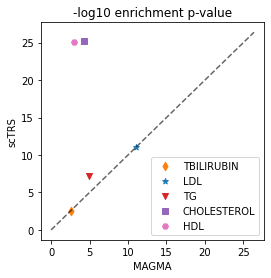

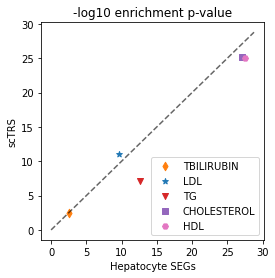

In [92]:
# Scatter plot for comparison 
dic_config = {'gwas': ['C0', 'MAGMA'], 
              'sctrs': ['C1', 'scTRS'], 
              'hep': ['C2', 'Hepatocyte SEGs']}

dic_config_trait = {'UKB_460K.biochemistry_TotalBilirubin': ['C1', 'd'], 
                    'UKB_460K.biochemistry_LDLdirect': ['C0', '*'], 
                    'UKB_460K.biochemistry_Triglycerides': ['C3', 'v'], 
                    'UKB_460K.biochemistry_Cholesterol': ['C4', 's'],
                    'UKB_460K.biochemistry_HDLcholesterol': ['C6', 'H'],
#                     'UKB_460K.disease_ALLERGY_ECZEMA_DIAGNOSED': ['C2', 'D']                   
                    }

df_plot = dic_stats[res][['GS']].copy()
for res in dic_config:
    df_plot['%s.nlog10pval'%res] = -np.log10(dic_stats[res].loc[df_plot.index, 'pval'].values)
df_plot = df_plot.astype(dtype=float)
df_plot['loc'] = range(df_plot.shape[0])

for res_ref in ['gwas', 'hep']:
    plt.figure(figsize=[4,4])
    ind_select = (~df_plot.index.isin(dic_config_trait.keys()))
    plt.scatter(df_plot.loc[ind_select, '%s.nlog10pval'%res_ref], df_plot.loc[ind_select, 'sctrs.nlog10pval'],
                color='k', alpha=0.2)
    for trait in dic_config_trait:
        plt.scatter(df_plot.loc[trait, '%s.nlog10pval'%res_ref], df_plot.loc[trait, 'sctrs.nlog10pval'], 
                    color=dic_config_trait[trait][0], marker=dic_config_trait[trait][1], 
                    label=DF_TRAIT_INFO.loc[trait, 'Code'])
    xmin,xmax = plt.xlim()
    ymin,ymax = plt.ylim()
    max_ = max(xmax, ymax)
    plt.plot([0, max_], [0, max_], '--', color='k', alpha=0.6)
    plt.xlabel(dic_config[res_ref][1])
    plt.ylabel(dic_config['sctrs'][1])
    plt.title('-log10 enrichment p-value')
    plt.legend(loc='lower right')
#     plt.tight_layout()
#     plt.savefig(FIG_PATH+'/comparison_gs_%s.svg'%res_ref)
    plt.show()

### Old code